In [124]:
import fastf1 as ff1
from fastf1 import plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import seaborn as sns
#from matplotlib import colors

In [71]:
# Setup plotting
plotting.setup_mpl()

# Enable the cache
ff1.Cache.enable_cache(r'C:\Users\User\Desktop\789\f1\ver_ham_new') 


# Get rid of some pandas warnings that are not relevant for us at the moment
pd.options.mode.chained_assignment = None 

In [72]:
# Load the session data
race = ff1.get_session(2021, 'Abu Dhabi', 'R')

In [73]:
# Get the laps
laps = race.load_laps(with_telemetry=True)

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\fastf1\core.py:1220: FutureWarning: `Session.load_laps` is deprecated and will beremoved in a future version.
Use `Session.load` instead.
  warnings.warn("`Session.load_laps` is deprecated and will be"
core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 19 drivers: ['33', '44', '55', '22', '10', '77

In [74]:
# Get laps of the drivers (VER and HAM)
laps_ham = laps.pick_driver('HAM')
laps_ver = laps.pick_driver('VER')

In [141]:
compound_ver = laps_ver['Compound']
compound_ver_list = compound_ver.values.tolist()

In [142]:
compound_ham = laps_ham['Compound']
compound_ham_list = compound_ham.values.tolist()

In [78]:
# Filling in the gaps of Verstappen's laps
verst_lap_1 = pd.Series(['0 days 00:01:32.800000', '0 days 00:02:30.435000'], index = [0, 54])
verst_lap_1_t = pd.to_timedelta(verst_lap_1)
laps_ver['LapTime'].fillna(value = verst_lap_1_t, inplace = True)

In [79]:
# Set the indexes in Hamilton's frame
laps_ham.reset_index(drop = True, inplace = True)

In [80]:
# Filling in the gaps of Hamilton's laps
ham_lap_1 = pd.Series(['0 days 00:01:31.686000', '0 days 00:02:32.083000'], index = [0, 54])
ham_lap_1_t = pd.to_timedelta(ham_lap_1)
laps_ham['LapTime'].fillna(value = ham_lap_1_t, inplace = True)

In [81]:
# Set the race lap
laps_ham['RaceLapNumber'] = laps_ham['LapNumber'] - 1
laps_ver['RaceLapNumber'] = laps_ver['LapNumber'] - 1

In [82]:
# create data frames
full_distance_ver_ham = pd.DataFrame()
summarized_distance_ver_ham = pd.DataFrame()

In [12]:
for lap in laps_ver.iterlaps():
    telemetry = lap[1].get_car_data().add_distance().add_driver_ahead()
    
    # Only run this loop when driver ahead is HAM, otherwise we compare wrong distance gaps
    telemetry = telemetry.loc[telemetry['DriverAhead'] == "44"]
    
    if len(telemetry) != 0:
        # Full distance
        lap_telemetry = telemetry[['Distance', 'DistanceToDriverAhead']]
        lap_telemetry.loc[:, 'Lap'] = lap[0] + 1

        #full_distance_ver_ham = full_distance_ver_ham.append(lap_telemetry)
        lap_telemetrydf = pd.DataFrame.from_records([lap_telemetry])
        full_distance_ver_ham = pd.concat([full_distance_ver_ham, lap_telemetrydf])

        # Average distance
        distance_mean = np.nanmean(telemetry['DistanceToDriverAhead'])
        
        
        row = {'Lap': lap[0] + 1, 'Mean': distance_mean}
        rowdf = pd.DataFrame.from_records([row])
        summarized_distance_ver_ham = pd.concat([summarized_distance_ver_ham, rowdf], ignore_index = True)

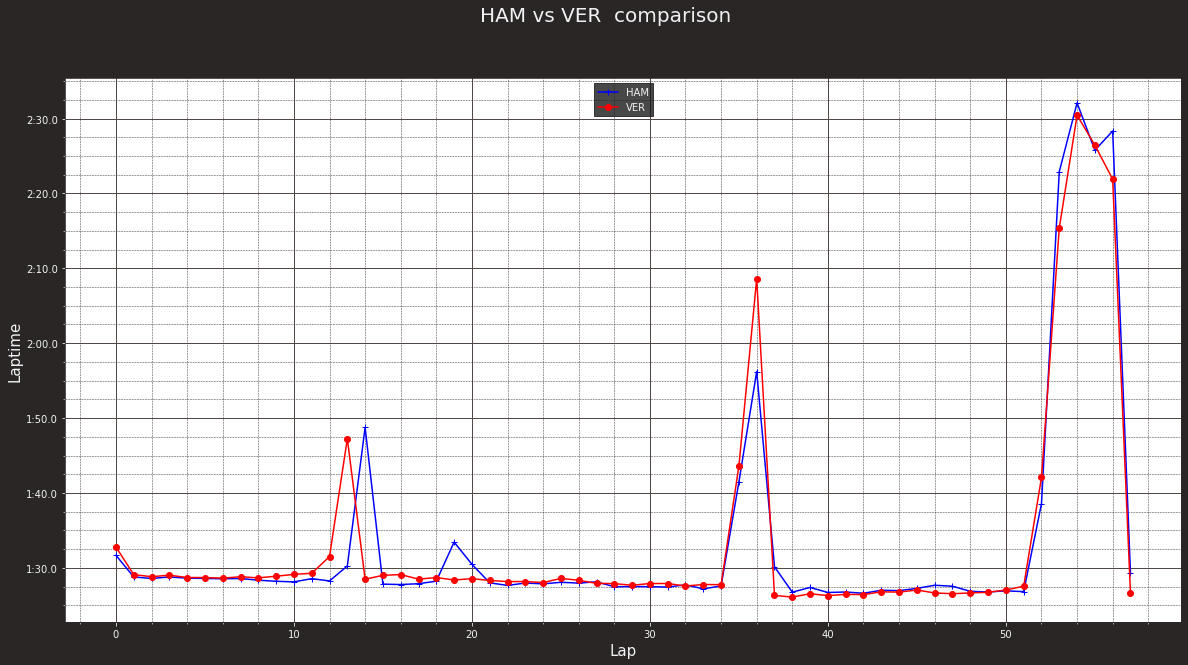

In [13]:
#plotting the first set
plt.rcParams['figure.figsize'] = [20, 10]

fig, ax = plt.subplots()
fig.suptitle("HAM vs VER  comparison", fontsize = 20)

ax.set_facecolor("white")


ax.plot(laps_ham['RaceLapNumber'], laps_ham['LapTime'], label='HAM', marker = '+', c = 'blue')
ax.plot(laps_ver['RaceLapNumber'], laps_ver['LapTime'], label='VER', marker = 'o', c = 'red')

plt.xlabel('Lap', fontsize = 15)
plt.ylabel('Laptime', fontsize = 15)
ax.legend(loc="upper center")

plt.show()


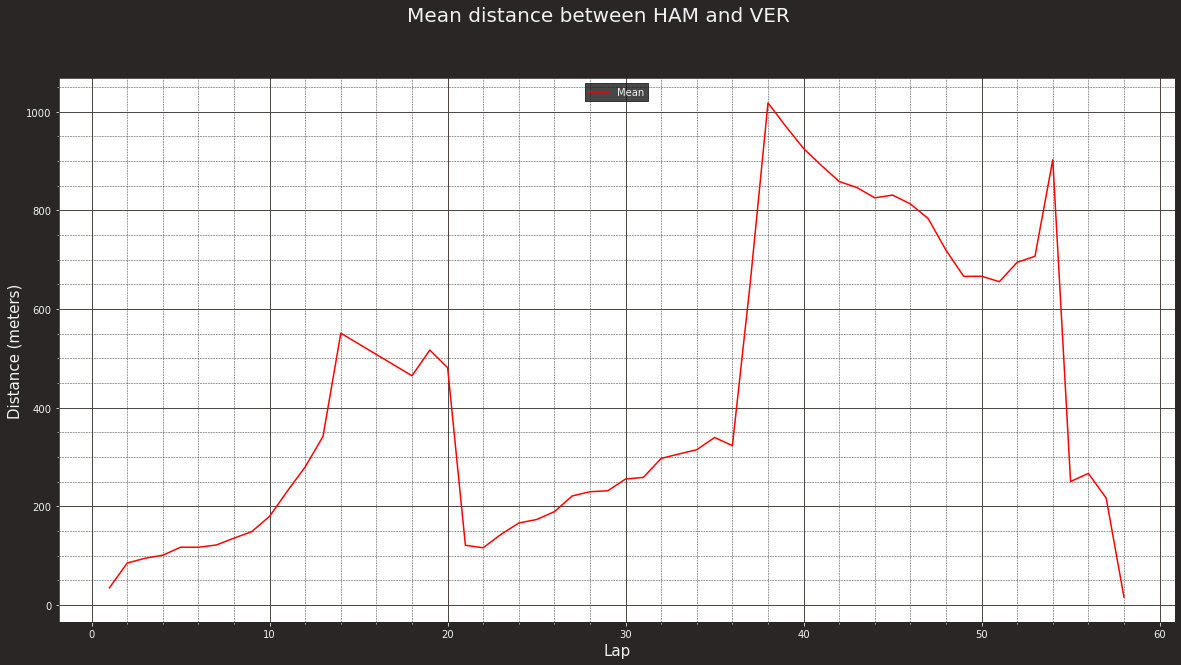

In [55]:
#plotting the second set
plt.rcParams['figure.figsize'] = [20, 10]

fig, ax = plt.subplots()
fig.suptitle("Mean distance between HAM and VER", fontsize = 20)

ax.set_facecolor("white")

ax.plot(summarized_distance_ver_ham['Lap'], summarized_distance_ver_ham['Mean'], label='Mean', color='red')

plt.xlabel('Lap', fontsize = 15)
plt.ylabel('Distance (meters)', fontsize = 15)
ax.legend(loc="upper center")

plt.show()

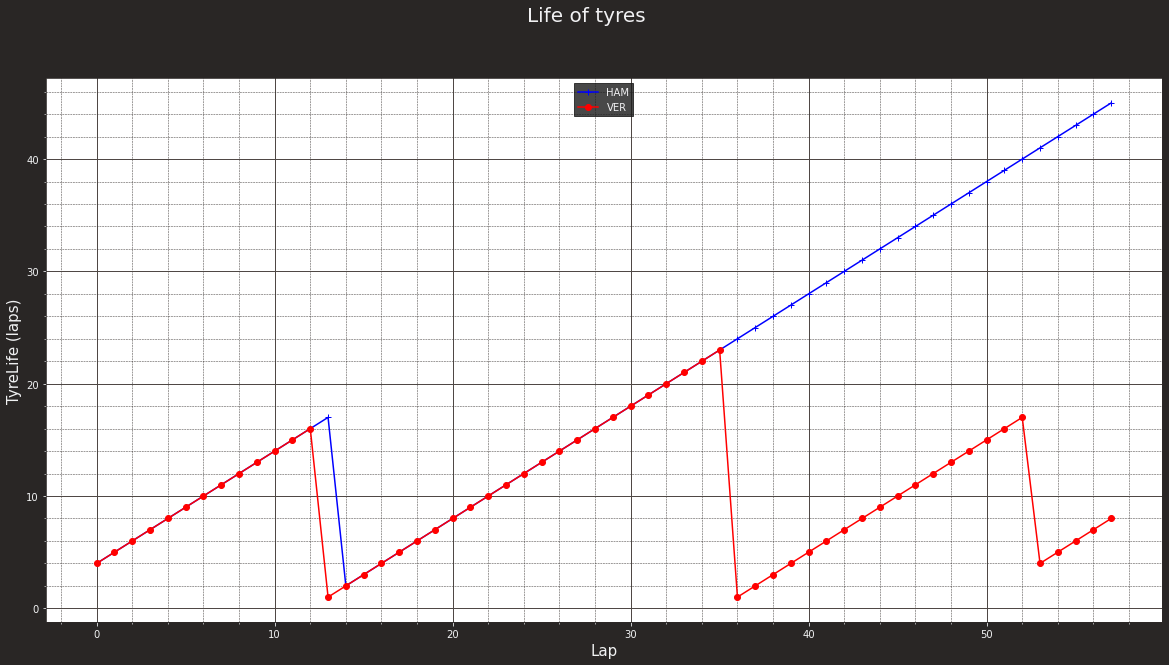

In [56]:
#plotting the third set
plt.rcParams['figure.figsize'] = [20, 10]

fig, ax = plt.subplots()
fig.suptitle("Life of tyres", fontsize = 20)

ax.set_facecolor("white")

ax.plot(laps_ham['RaceLapNumber'], laps_ham['TyreLife'], label='HAM', marker = '+',  c = 'blue')
ax.plot(laps_ver['RaceLapNumber'], laps_ver['TyreLife'], label='VER', marker = 'o', c = 'red')

plt.xlabel('Lap', fontsize = 15)
plt.ylabel('TyreLife (laps)', fontsize = 15)
ax.legend(loc="upper center")        


plt.show()

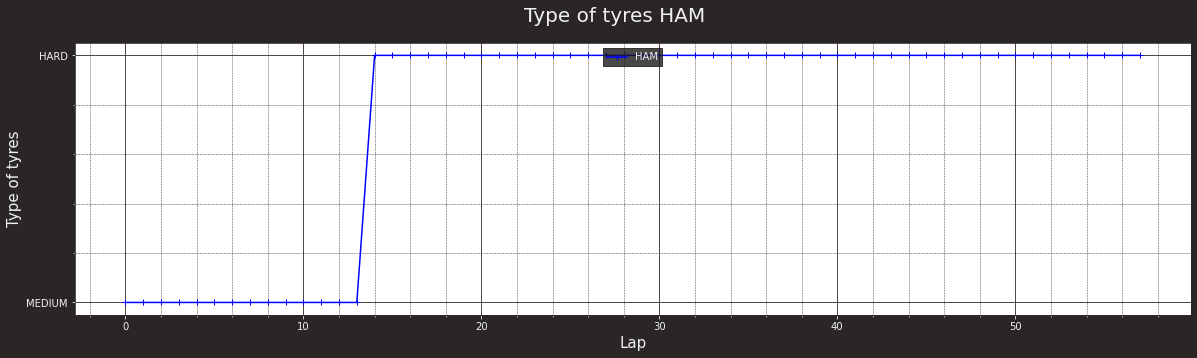

In [59]:
#plotting the forth set
plt.rcParams['figure.figsize'] = [20, 5]

fig, ax = plt.subplots()
fig.suptitle("Type of tyres HAM", fontsize = 20)

ax.set_facecolor("white")

ax.plot(laps_ham['RaceLapNumber'], laps_ham['Compound'], label='HAM', marker = '+',  c = 'blue')

plt.xlabel('Lap', fontsize = 15)
plt.ylabel('Type of tyres', fontsize = 15)
ax.legend(loc="upper center")

plt.show()

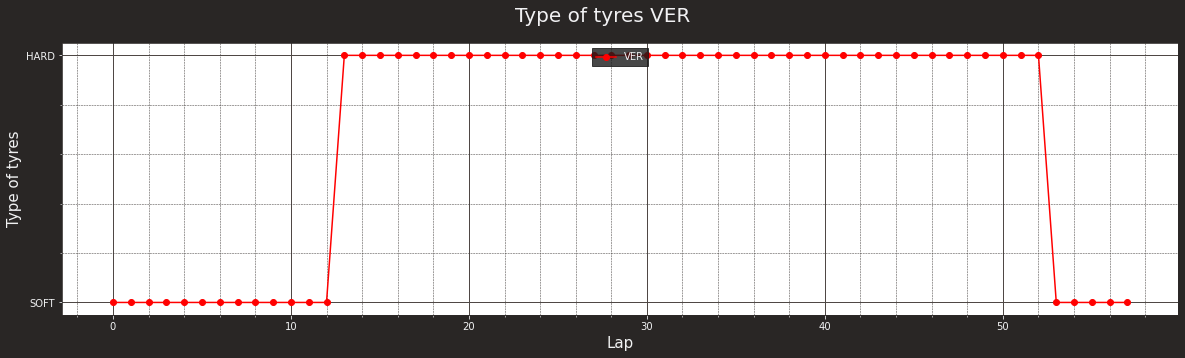

In [63]:
#plotting the fifth set
plt.rcParams['figure.figsize'] = [20, 5]

fig, ax = plt.subplots()
fig.suptitle("Type of tyres VER", fontsize = 20)

ax.set_facecolor("white")

ax.plot(laps_ver['RaceLapNumber'], laps_ver['Compound'], label='VER', marker = 'o', c = 'red')
plt.xlabel('Lap', fontsize = 15)
plt.ylabel('Type of tyres', fontsize = 15)

ax.legend(loc="upper center")


plt.show()

In [148]:
def colorst(list):
    color = []
    a = 'a'
    for i in list: 
        if i == 'HARD':
            a = 'white'
            color.append(a)
        elif i == 'SOFT':
            a = 'red'
            color.append(a)
        else:
            a = 'yellow'
            color.append(a)
    return color 

In [143]:
color_ver = colorst(compound_ver_list)

In [149]:
color_ham = colorst(compound_ham_list)

In [213]:
size = (20, 200)
label_type = {'SOFT':'red', 'HARD':'white', 'MEDIUM': 'yellow'}

In [278]:
sns.set()

Text(0.5, 1.0, 'Verstappen TyreLife')

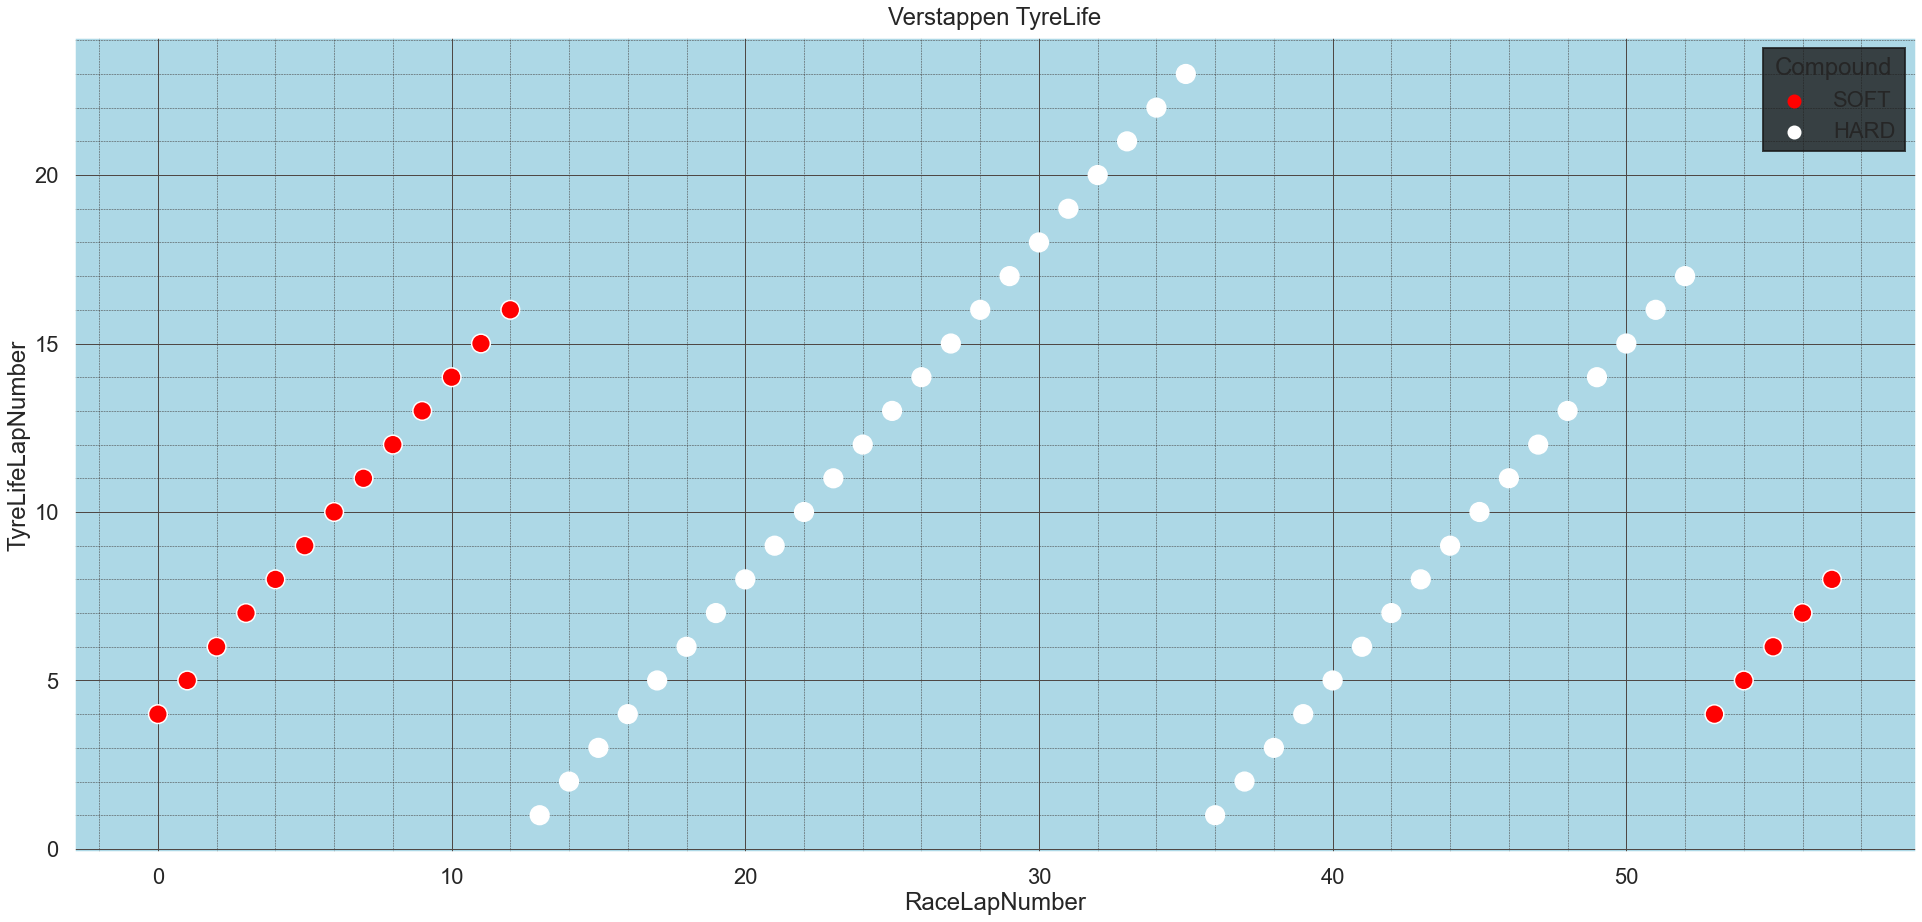

In [296]:
fig, ax = plt.subplots(figsize = ( 33 , 15))
sns.set_theme(style = 'darkgrid')
sns.set_style(rc={'axes.facecolor':'lightblue'})
ax.set_xlabel('RaceLapNumber')
ax.set_ylabel('TyreLifeLapNumber')
#ax.legend((l1, l2), ('oscillatory', 'damped'), shadow = True)
sns.set_context('poster')
sns.scatterplot(x = laps_ver['RaceLapNumber'],y = laps_ver['TyreLife'],  hue = laps_ver['Compound'], marker = 'o', s = 350, palette = label_type).set_title('Verstappen TyreLife')


In [285]:
help(sns.set_style)

Help on function set_style in module seaborn.rcmod:

set_style(style=None, rc=None)
    Set the parameters that control the general style of the plots.
    
    The style parameters control properties like the color of the background and
    whether a grid is enabled by default. This is accomplished using the
    :ref:`matplotlib rcParams system <matplotlib:matplotlib-rcparams>`.
    
    The options are illustrated in the
    :doc:`aesthetics tutorial <../tutorial/aesthetics>`.
    
    See :func:`axes_style` to get the parameter values.
    
    Parameters
    ----------
    style : dict, or one of {darkgrid, whitegrid, dark, white, ticks}
        A dictionary of parameters or the name of a preconfigured style.
    rc : dict, optional
        Parameter mappings to override the values in the preset seaborn
        style dictionaries. This only updates parameters that are
        considered part of the style definition.
    
    Examples
    --------
    
    .. include:: ../docstrings